# Multi-material modelling: LiPb pipe flow

In this task, we'll simulate the flow of LiPb in a pipe consisting of a fluid and solid domain.

Natively, advection is not taken into account in FESTIM. The idea is therefore to modify the governing equations by adding an advection term.

In [446]:
import festim as F

my_model = F.Simulation()

Create a mesh with FEniCS and mark the subdomains.

For more information on FEniCS meshes, please visit [the mesh demo](https://fenicsproject.org/olddocs/dolfin/latest/python/demos/built-in-meshes/demo_built-in-meshes.py.html) and the [subdomains demo](https://fenicsproject.org/pub/tutorial/sphinx1/._ftut1005.html).

In [447]:
# ids of mesh subdomains
id_fluid = 6
id_pipe_walls = 7

id_inlet = 8
id_top_surface = 9
id_bottom_surface = 10

# Read mesh file
my_model.mesh = F.MeshFromXDMF(
    volume_file="task3/mesh_domains.xdmf",
    boundary_file="task3/mesh_boundaries.xdmf",
)

Succesfully load mesh with 41406 cells


![mesh_image](https://github.com/RemDelaporteMathurin/FESTIM/assets/65899899/f7ef32db-fe3f-4a8b-ad24-e93f258dc0c5)

Let's add the rest of the parameters.
For this case, the concentration will be set to 1 on the left surface and to zero on the top and bottom surfaces.

In [448]:
eurofer = F.Material(
    id=id_pipe_walls,
    D_0=3.15e-08,
    E_D=0.0622,
    S_0=2.4088e23,
    E_S=0.3026,
)
lipb = F.Material(
    id=id_fluid,
    D_0=4.03e-08,
    E_D=0.2021,
    S_0=1.427214e23,
    E_S=0.133,
)

my_model.materials = F.Materials([
    eurofer, lipb
])

my_model.T = F.Temperature(600)

my_model.boundary_conditions = [
    F.DirichletBC(field="solute", surfaces=id_top_surface, value=0),
    F.DirichletBC(field="solute", surfaces=id_bottom_surface, value=0),
    F.DirichletBC(field="solute", surfaces=id_inlet, value=1e16)
]

my_model.exports = F.Exports(
    [F.XDMFExport("solute", folder="task3/", mode=1)]
)

my_model.settings = F.Settings(
    absolute_tolerance=1e10,
    relative_tolerance=1e-10,
    transient=False,
    chemical_pot=True,
    )

We can now run the pure diffusion simulation and visualise the hydrogen concentration field.

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Solving steady state problem...
Solved problem in 0.30 s


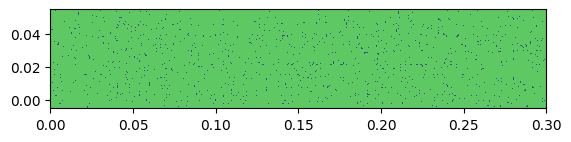

In [449]:
from fenics import plot

my_model.initialise()
my_model.run()

plot(my_model.h_transport_problem.mobile.solution)



## Adding advection

Let's now add an advection term. To do so, we first need to create a velocity field.
For simplicity sake, we will create an arbitrary field `velocity`.

> 
> Note: this velocity field can be obtained from solving the Navier-Stokes equations with FEniCS or with another code (OpenFOAM).
> 

In [450]:
from fenics import interpolate, Expression, VectorFunctionSpace, SubMesh, XDMFFile, Function, TestFunction, solve, inner

mesh_sub = SubMesh(my_model.mesh.mesh, my_model.mesh.volume_markers, id_fluid)

functionspace = VectorFunctionSpace(mesh_sub, "CG", 1)

velocity = Expression(("6e-03*x[1]*(x[1] - 0.05)", "0"), degree=2)

velocity = interpolate(velocity, functionspace)

V = VectorFunctionSpace(my_model.mesh.mesh, "CG", 1)
u = Function(V)
v = TestFunction(V)

F = inner(u, v) * my_model.mesh.dx
F += inner(velocity, v) * my_model.mesh.dx(id_fluid)
solve(F == 0, u, bcs=[])

XDMFFile("task3/velocity_field.xdmf").write(u)



Here's what `velocity` looks like:

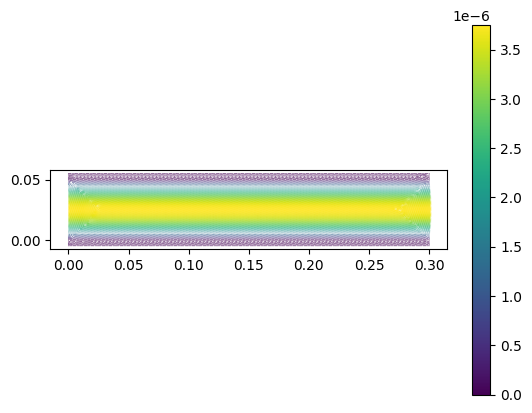

In [451]:
import matplotlib.pyplot as plt

CS = plot(u)
plt.colorbar(CS)
plt.show()

Now that we created a FEniCS function representing the velocity, let's add an advection term to the governing equation.

The governing equation for steady state advection-diffusion is:

$$\nabla \cdot (D \nabla c) - v \cdot \nabla c = 0$$

where $D$ is the diffusion coefficient, $c$ is the hydrogen concentration and $v$ is the velocity.

To modify the governing equations, one needs to modify the formulation of the H transport problem.
It can be accessed in `my_model.h_transport_problem.F`.

See [this FEniCS tutorial](https://fenicsproject.org/pub/tutorial/html/._ftut1010.html) for more information on finite element formulations.

In [452]:
print(my_model.h_transport_problem.F)

{ ({ A | A_{i_{831}} = (grad(c * 1.427214e+23 * exp(-1543.401440699099 / T)))[i_{831}] * 4.03e-08 * exp(-2345.2739185359997 / T) }) . (grad(v_0)) } * dx(<Mesh #13017>[6], {})
  +  { ({ A | A_{i_{830}} = (grad(c * 2.4088e+23 * exp(-3511.5283906432132 / T)))[i_{830}] * 3.15e-08 * exp(-721.8012752743156 / T) }) . (grad(v_0)) } * dx(<Mesh #13017>[7], {})


In [453]:
from fenics import inner, dot, grad, exp
from festim import k_B

my_model.initialise() # reinitialisation is needed

hydrogen_concentration = my_model.h_transport_problem.mobile.solution
test_function_solute = my_model.h_transport_problem.mobile.test_function
S_lipb = lipb.S_0 * exp(lipb.E_S / k_B / my_model.T.T)

advection_term = inner(dot(grad(S_lipb * hydrogen_concentration), u), test_function_solute) * my_model.mesh.dx(id_fluid)

my_model.h_transport_problem.F += advection_term
print(my_model.h_transport_problem.F)

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
{ ({ A | A_{i_{833}} = (grad(c * 1.427214e+23 * exp(-1543.401440699099 / T)))[i_{833}] * 4.03e-08 * exp(-2345.2739185359997 / T) }) . (grad(v_0)) } * dx(<Mesh #13017>[6], {})
  +  { (conj((v_0))) * ((grad(c * 1.427214e+23 * exp(1543.401440699099 / T))) . (f_13182)) } * dx(<Mesh #13017>[6], {})
  +  { ({ A | A_{i_{832}} = (grad(c * 2.4088e+23 * exp(-3511.5283906432132 / T)))[i_{832}] * 3.15e-08 * exp(-721.8012752743156 / T) }) . (grad(v_0)) } * dx(<Mesh #13017>[7], {})


Now that the governing equation has been modified, let's run the simulation again and check the new concentration field.

Solving steady state problem...
Solved problem in 0.80 s


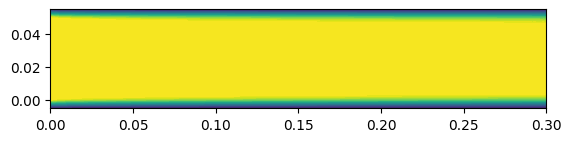

In [454]:
my_model.run()
plot(my_model.h_transport_problem.mobile.solution)
XDMFFile("task3/mobile_conc_with_advection.xdmf").write(my_model.h_transport_problem.mobile.solution)
# plot(velocity)
plt.show()

The concentration field is greatly affected as particles are now pushed towards the right hand side of the domain.

# Task:

Vary the velocity field to investigate its influence on the mobile concentration